This Jupyter Notebook contains code to do the following:
- ff

The notebook is divided into sections and each code block is suplemented with comments and markdown text to guide the user about whats going on.

All or parts of the code from this notebook can be easily copied to create standalone python script files.
Further information about the methods used in this notebook can be found in the following papers:
- https://arxiv.org/abs/2511.12685
- 


# Initialization

In [8]:
# importing necessary libraries
import os
import sys
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from src.configManager import ConfigManager
import xarray as xr

config = ConfigManager()

In [9]:
# code to set up matplotlib and seaborn styles

plt.style.use('default')

# Save the default rcParams to revert back if needed
dflt_rcParams = mpl.rcParams.copy()

# Change the default font
mpl.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})

# Increase the font size for better readability
mpl.rcParams.update({'font.size': 14, 
                     'axes.titlesize': 14,
                     'axes.titleweight': 'bold', 
                     'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12, 
                     'legend.fontsize': 11})

# Remove the top and right spines for a cleaner look
mpl.rcParams.update({'axes.spines.right': False, 
                     'axes.spines.top': False,
                     'axes.spines.left': True,
                     'axes.spines.bottom': True})

# Add space between the plot and the title
mpl.rcParams.update({'axes.titlepad': 15})

# Set the figure size for all plots
mpl.rcParams.update({'figure.figsize': (10, 6)})

# Set the style for seaborn
sns.set_style("white")  # other options: "dark", "whitegrid", "darkgrid", "ticks"

In [51]:
state = config.get('processing_parameters')['state']
county = config.get('processing_parameters')['county']
start_year = config.get('processing_parameters')['start_year']
end_year = config.get('processing_parameters')['end_year']

ds_merged = xr.open_dataset(os.path.join(
    config.get("data_paths.merged_data_dir"),
    state,
    config.get("file_patterns.merged_file_pattern").format(
        state=state,
        county=county,
        start=start_year,
        end=end_year
    )
))  

# Exploring the Merged Data

In [ ]:
# check the different details of the dataset in an interactive viewer
ds_merged

<xarray.Dataset> Size: 40MB
Dimensions:              (time: 385728, station: 4)
Coordinates:
  * time                 (time) datetime64[ns] 3MB 2014-01-01 ... 2024-12-31T...
  * station              (station) <U3 48B 'HST' 'MIA' 'OPF' 'TMB'
    lat                  (station) <U7 112B ...
    lon                  (station) <U8 128B ...
Data variables:
    tmpf                 (time, station) float32 6MB ...
    sknt                 (time, station) float32 6MB ...
    gust                 (time, station) float32 6MB ...
    p01i                 (time, station) float32 6MB ...
    poccurence           (time, station) float32 6MB ...
    customers_out        (time) int64 3MB ...
    outage_event_number  (time) int64 3MB ...
Attributes:
    title:                Merged Weather and Outage Data for Miami-Dade, Flor...
    description:          This dataset contains weather data from multiple st...
    state:                Florida
    county:               Miami-Dade
    start_year:           2014
    end_year:             2024
    creation_date:        2026-01-18 17:03:35
    temporal_resolution:  15 minutes
    county_fips_code:     12086

In [14]:
# get the timeseries range of the merged dataset
print(ds_merged['time'].values[0], ds_merged['time'].values[-1])

2014-01-01T00:00:00.000000000 2024-12-31T23:45:00.000000000


In [21]:
# get all the variables in the dataset
print(ds_merged.data_vars)

Data variables:
    tmpf                 (time, station) float32 6MB ...
    sknt                 (time, station) float32 6MB ...
    gust                 (time, station) float32 6MB ...
    p01i                 (time, station) float32 6MB ...
    poccurence           (time, station) float32 6MB ...
    customers_out        (time) int64 3MB ...
    outage_event_number  (time) int64 3MB ...


In [17]:
# get all the stations available in the merged dataset
print(ds_merged['station'].values)

['HST' 'MIA' 'OPF' 'TMB']


In [ ]:
# get all the data for a specific station, e.g., 'MIA'
ds_merged.sel(station='MIA')

<xarray.Dataset> Size: 17MB
Dimensions:              (time: 385728)
Coordinates:
  * time                 (time) datetime64[ns] 3MB 2014-01-01 ... 2024-12-31T...
    station              <U3 12B 'MIA'
    lat                  <U7 28B ...
    lon                  <U8 32B ...
Data variables:
    tmpf                 (time) float32 2MB ...
    sknt                 (time) float32 2MB ...
    gust                 (time) float32 2MB ...
    p01i                 (time) float32 2MB ...
    poccurence           (time) float32 2MB ...
    customers_out        (time) int64 3MB ...
    outage_event_number  (time) int64 3MB ...
Attributes:
    title:                Merged Weather and Outage Data for Miami-Dade, Flor...
    description:          This dataset contains weather data from multiple st...
    state:                Florida
    county:               Miami-Dade
    start_year:           2014
    end_year:             2024
    creation_date:        2026-01-18 17:03:35
    temporal_resolution:  15 minutes
    county_fips_code:     12086

In [22]:
# select all values of a particular weather variable at a specific time (for all stations in the dataset in order)
print(ds_merged['tmpf'].sel(time='2020-06-15 12:00:00').values)

[78.6 79.  79.  80. ]


In [23]:
# select a particular weather variable for a specific station at a specific time
print(ds_merged['tmpf'].sel(station='MIA', time='2020-06-15 12:00:00').values)

79.0


In [34]:
ds_merged['customers_out'].sel(time='2020-06-15 12:00:00').values

array(41)

In [26]:
# Select time range and get all data
data = ds_merged.sel(time=slice('2020-06-15', '2020-06-16'))

# Access weather from specific station
station_weather = data.sel(station='MIA')

# Access outage data for the time period
outages = data['customers_out']

In [30]:
outages.values

array([  57,   44,   91,   89,   53,   56,   57,   43,   43,   50,   49,
       1051, 1105, 1104,  729,  767,  475,  262,  197,  197,  153,  153,
         23,   38,   62,   56,   56,   56,   56,  114,  114,  114,   67,
         67,   67,   42,   43,   44,   26,  117,   25,   25,   25,   25,
         26,   37,   41,   42,   41,  152,  154,  175,  175,  180,   74,
         75,   69,   70,  106,  114,  151,  117,  127,  107,   83,   71,
         73,   79,   73,   65,   65,   66,   64,   67,   97,  109,  111,
        111,   80,  260,  355,  378,  389,  393,  362,  366,  326,  470,
        670,  676,  641,  687,  639,  548,  541,  499,  435,  372, 1285,
        450,  450,  451,  493,  277,  305,  305,  305,  300,  295,  401,
        300,  274,  272,  273,  141,  141,  141,  142,  141,  143,  143,
        142,  100,   94,   25,  133,   32,   45,   62,   52,   50,   49,
         41,   48,   48,   46,   34,   54,   54,   55,   55,   55,   68,
        101,  115,  159,  161,  165,  166,  140,  1

# Analyzing Events in the EAGLE-I Outage Data

In [64]:
# create a dataframe of customers_out and event_number_eaglei from the xarray dataset
outage_df = ds_merged[['customers_out', 'event_number_eaglei']].to_dataframe().reset_index()
print(f"Size of the outage dataframe: {outage_df.shape}")
# keep only rows where customers_out > 0
outage_df = outage_df[outage_df['customers_out'] > 0]
print(f"Size of the outage dataframe after filtering customers_out > 0: {outage_df.shape}")

Size of the outage dataframe: (385728, 3)
Size of the outage dataframe after filtering customers_out > 0: (351202, 3)


In [63]:
outage_df.head()

,time,customers_out,event_number_eaglei
29200,2014-11-01 04:00:00,72,1
29201,2014-11-01 04:15:00,72,1
29202,2014-11-01 04:30:00,216,1
29203,2014-11-01 04:45:00,213,1
29204,2014-11-01 05:00:00,210,1


In [65]:
# Total number of outage events
print(f"Total number of outage events: {outage_df['event_number_eaglei'].nunique()}")
# Total number of outage events, excluding the ones that don't meet the customers_out threshold
customers_out_threshold = config.get('data_cleaning_parameters')['events_customer_threshold']
print(f"Total number of outage events (customers_out > {customers_out_threshold}): {outage_df[outage_df['customers_out'] >= customers_out_threshold]['event_number_eaglei'].nunique()}")

Total number of outage events: 9439
Total number of outage events (customers_out > 30): 4696


In [54]:
# Size of the top 10 longest outage events (longest in terms of number of records)
# Since each record represents a 15-minute interval, it is a proxy for duration
print(outage_df.groupby('event_number_eaglei')
                          .size()
                          .sort_values(ascending=False)
                          .head(10))

event_number_eaglei
3171    3489
8021    2867
9163    1748
3951    1712
8029    1529
3169    1499
8786    1459
9211    1338
5022    1244
8623    1204
dtype: int64


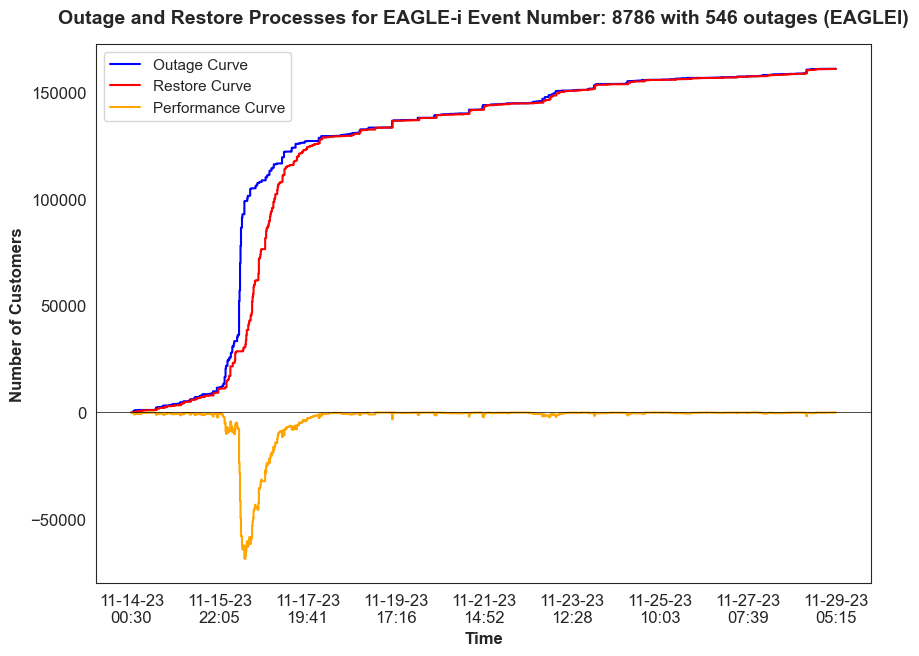

In [94]:
from src.eaglei_modules.eagleiEventProcessing import plot_eaglei_event_curves
plot_eaglei_event_curves(outage_df, event_number=8786, event_method='eaglei', timestamp_column='time')

# Analyzing Weather Data

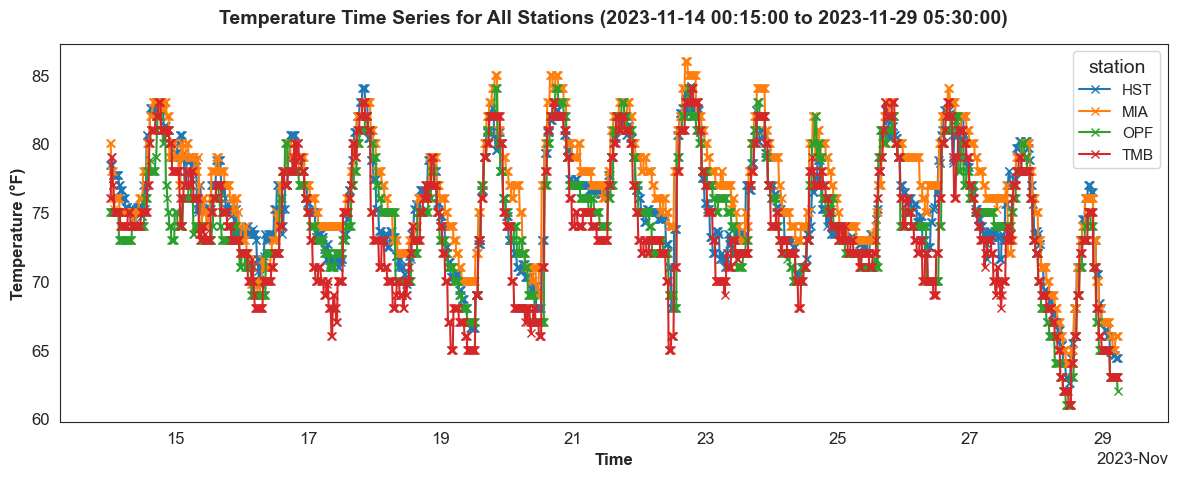

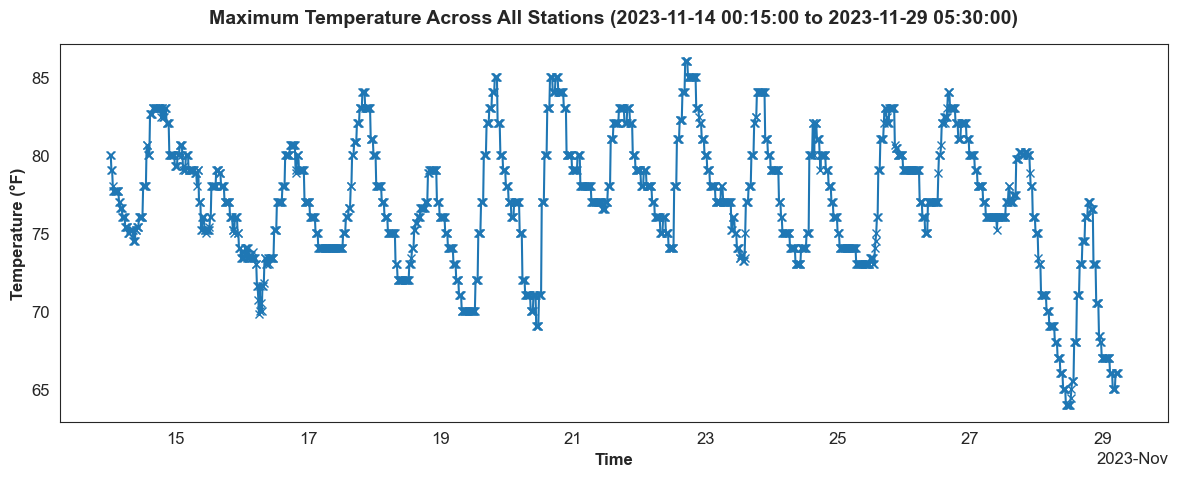

In [95]:
# plot a time series of temperature for all the stations for a given time period
time_from = '2023-11-14 00:15:00'
time_to = '2023-11-29 05:30:00'
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['tmpf'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Temperature Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Temperature (°F)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum temperature across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['tmpf'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Temperature Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Temperature (°F)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

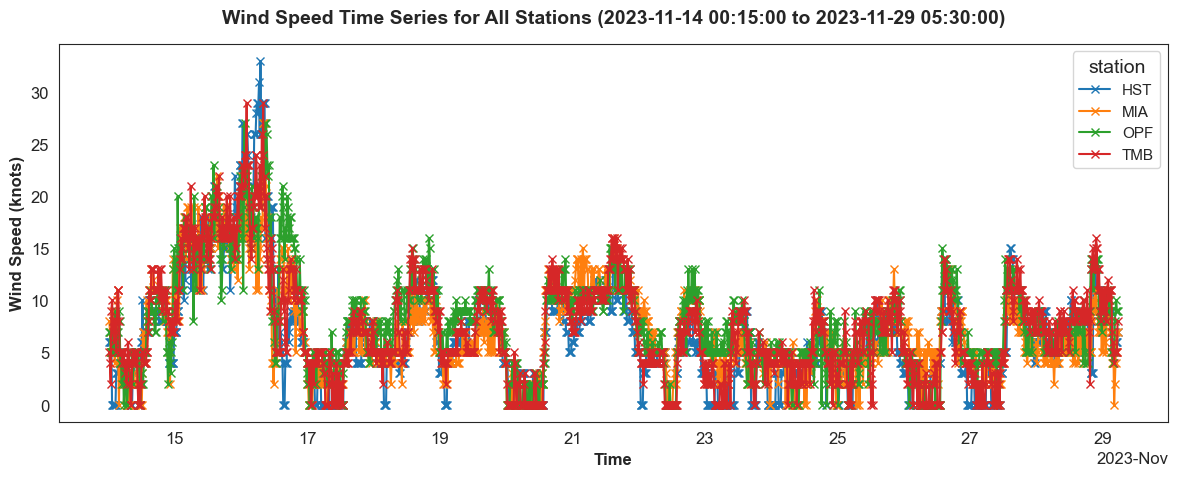

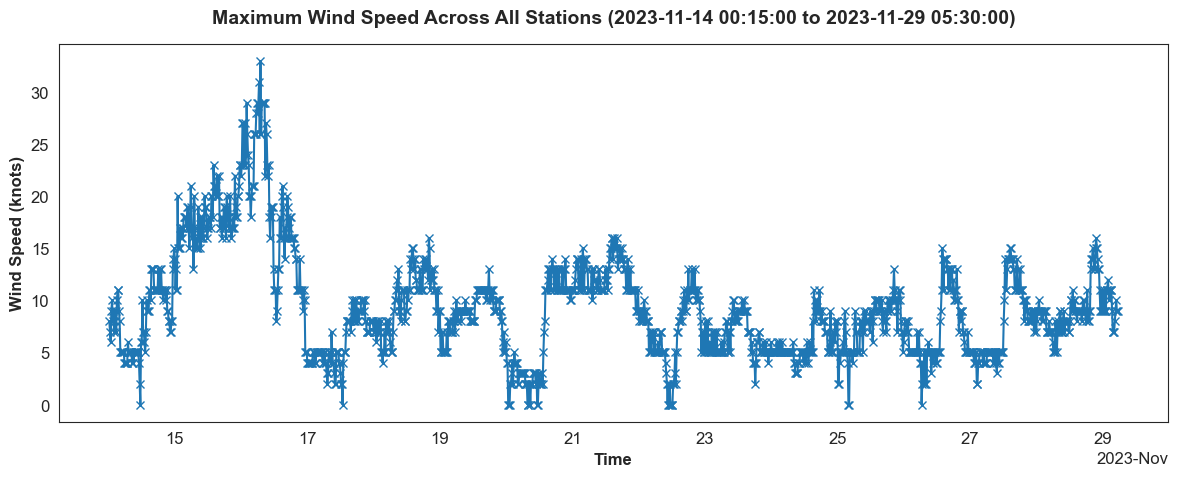

In [96]:
# plot a time series of wind speed for all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['sknt'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Wind Speed Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Speed (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum wind speed across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['sknt'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Wind Speed Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Speed (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

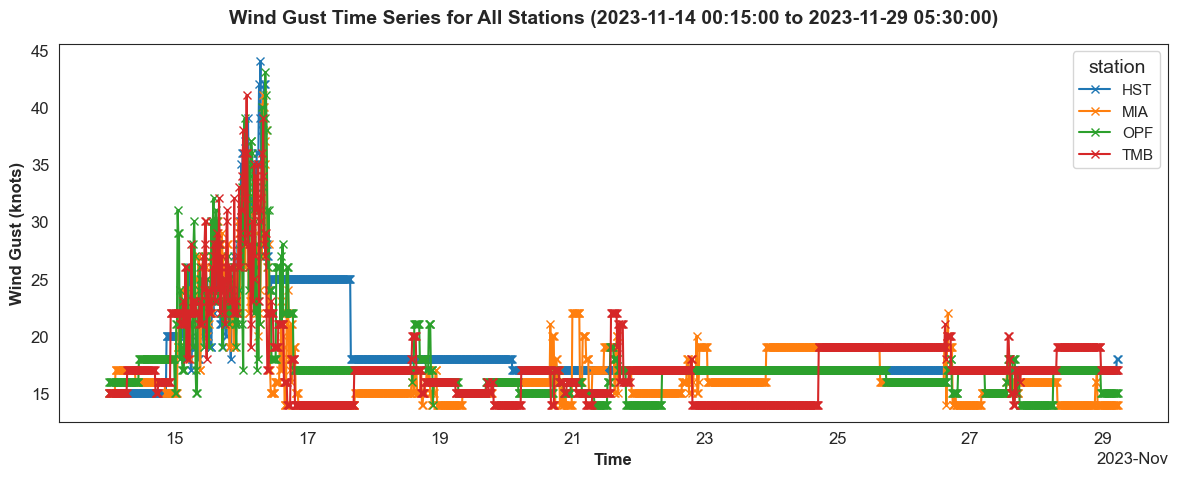

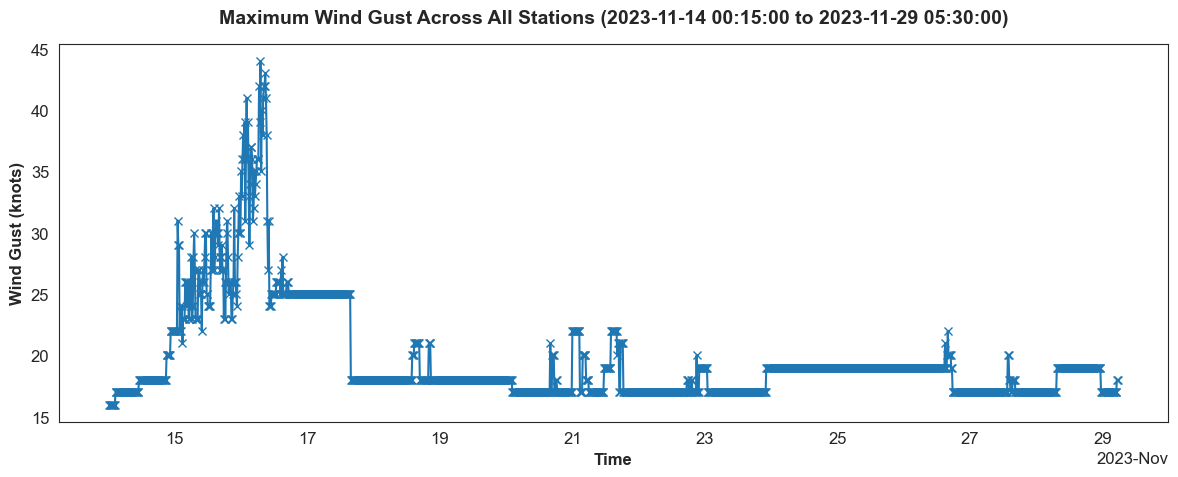

In [97]:
# plot a time series of wind gust for all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['gust'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Wind Gust Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Gust (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum wind gust across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['gust'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Wind Gust Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Gust (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

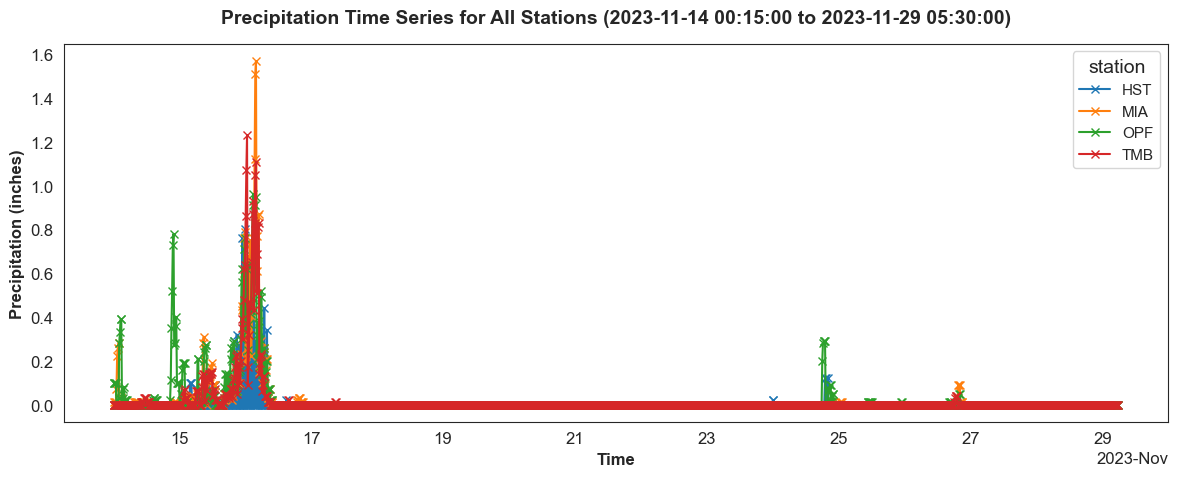

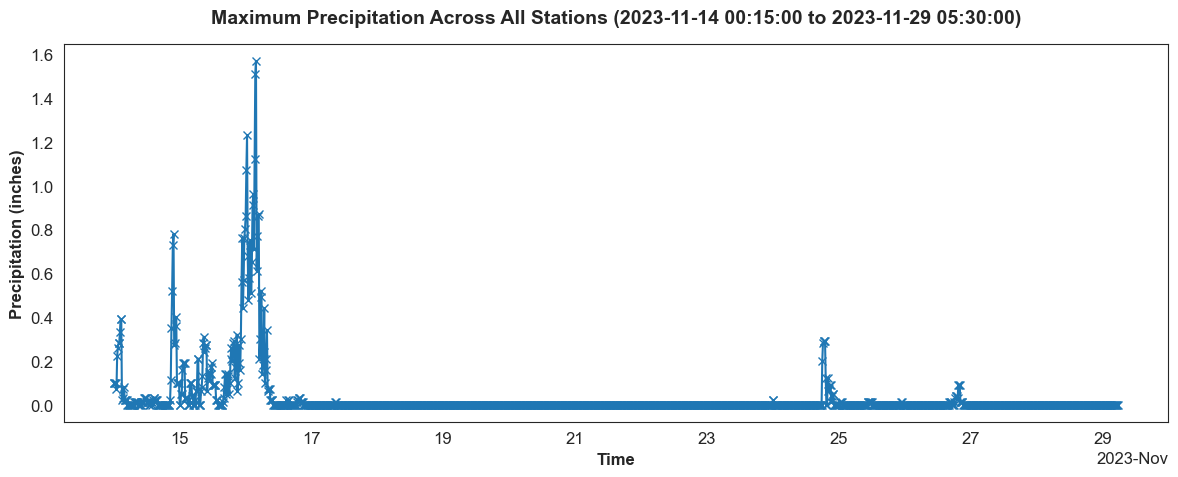

In [98]:
# plot a time series of precipitation for all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['p01i'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Precipitation Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Precipitation (inches)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum precipitation across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['p01i'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Precipitation Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Precipitation (inches)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# Analyzing Weather and Outage Data Together

In [ ]:
# outage time series with weather time series of each weather variable, for each station

In [ ]:
# selecting the maximum value of each weather variable across all stations, similar to what was alredy done in merge_outage_weather.py

# Event Statistics

In [110]:
# get a single dataframe merging customers_out, event_number_eaglei and maximum weather variables across all stations
temp1 = ds_merged[['customers_out', 'event_number_eaglei']].to_dataframe().reset_index()
temp2 = ds_merged[['tmpf', 'sknt', 'gust', 'p01i']].max(dim='station').to_dataframe().reset_index()
merged_weather_outage_df = pd.merge(temp1, temp2, on='time')

In [111]:
merged_weather_outage_df

,time,customers_out,event_number_eaglei,tmpf,sknt,gust,p01i
0,2014-01-01 00:00:00,0,0,74.0,12.0,19.0,0.00
1,2014-01-01 00:15:00,0,0,74.0,12.0,19.0,0.00
2,2014-01-01 00:30:00,0,0,74.0,12.0,19.0,0.00
3,2014-01-01 00:45:00,0,0,74.0,12.0,19.0,0.00
4,2014-01-01 01:00:00,0,0,74.0,12.0,19.0,0.00
...,...,...,...,...,...,...,...
385723,2024-12-31 22:45:00,154,9439,78.0,5.0,19.0,0.01
385724,2024-12-31 23:00:00,154,9439,78.0,6.0,19.0,0.01
385725,2024-12-31 23:15:00,141,9439,78.0,7.0,19.0,0.00
385726,2024-12-31 23:30:00,140,9439,78.0,7.0,19.0,0.00
